In [156]:
import pandas as pd
import operator
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing as pp
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV,Ridge,RidgeCV
from sklearn.model_selection import cross_val_score,learning_curve,train_test_split
from sklearn.pipeline import make_pipeline

Постановка
Разработать модель, позволяющую на основе задаваемых пользователем значений признаков, построить предварительную оценку стоимости квартиры.

ЗАДАЧИ
1. Очистить данные
2. Построить гипотезы о параметрах модели
3. Проверить с обучением и валидацией
4. Создать новый алгоритм или изменить параметры старой модели

1. Выбрать параметр оптимизации модели
2. Подать алгоритму данные и модель
3. Повторить процесс

Лучшую модель обернуть в сервис или контейнер

Модели
  метод LinearRegression — линейная регрессия, 
  GradientBoostingRegressor — градиентный бустинг.


ЭТАПЫ
1. Выполнить предобработку данных (preprocessing):
  Очистка данных
  Анализ и удаление выбросов
  Анализ и восстановление пропусков
  Стандартизация данных
  Выделение характерных признаков  
2. Выполнить вычисления по модели многомерной линейной регрессии и провести анализ полученной модели:
  Оценить качество регрессии по коэффициенту детерминации
  Оценить ошибку RMSE
  Выделить значимые и незначимые коэффициенты регрессии 

Посмотрим на датасет и проведем очистку данных


In [133]:
ds=pd.read_csv('data.csv')


In [134]:
#информация по уровню преступности в штатах
#https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%88%D1%82%D0%B0%D1%82%D0%BE%D0%B2_%D0%A1%D0%A8%D0%90_%D0%BF%D0%BE_%D1%83%D1%80%D0%BE%D0%B2%D0%BD%D1%8E_%D1%83%D0%B1%D0%B8%D0%B9%D1%81%D1%82%D0%B2
state_info = pd.read_csv('state_info.csv')

In [135]:
#чистим данные удаляя спец символы и приводя к числовому типу, категориальные признаки преобразуем в дамми-переменные
def clear(data_frame):
    df = data_frame.copy()
    df.drop_duplicates(inplace = True)

    
#TARGET
#Выбросим  значения  меньше 20 000, т.к. в основном стоимость жилья не может быть меньше 20.000$
#Источник https://immigrant.today/usa/14791-skolko-stoit-zhile-v-kazhdom-shtate-ameriki.htm
    df['target_new'] = pd.to_numeric(df['target'].str.replace('\D', ''), errors='coerce')
    df = df[~df['target_new'].isnull()]
    df = df.drop(df[df.target_new<20000].index)
    df=df.reset_index(drop=True)
#STATUS
#на первом этапе мучений преобразовывала 8 топовых значений статусов в дамми-переменные, не особо помогло
#на втором заходе попробую вариант коллег:
#Распределим статусы продажи от 0 до 1. Для статусов, обозначающих, что объект продается выставим параметр 0.5, 
#если покупатель уже найден - 1, если объект планируется к продаже - 0 
#(согласно сайту https://www.redfin.com/definition/single-family-residence)
    df['status'] = df['status'].str.lower()
    def map_status(s_status):
        if 'forec' or 'active' in s_status:
            return float(0)
        if 'sale' or 'new' or 'auction' in s_status:
            return float(0.5)
        if 'under' or 'pending' or 'сonting' in s_status:
            return float(1)
        else:
            return float(-1)
    new_col = df['status'].apply(map_status)
    df.status_new = new_col
    df = df.drop(df[df.status_new == -1].index)
#POOL
    df['PrivatePool'].fillna('no',inplace=True)
    df['private pool'].fillna('no',inplace=True)
    df['PrivatePool'] = df['PrivatePool'].str.lower()
    df['private pool'] = df['private pool'].str.lower()
    level_map = {'yes': 1, 'no': 0}
    df['PrivatePool'] = df['PrivatePool'].map(level_map)
    df['private pool'] = df['private pool'].map(level_map)
    df['pool_new'] = df[['PrivatePool','private pool']].max(axis =1)

#PROPERTYTYPE
#https://www.redfin.com/resources/difference-between-building-types)
#попытаемся унифицировать используемые в столбце названия для типов жилья
#заменим совпадающие категории одним названием
    
    df['propertyType_new'] = df['propertyType'].str.lower()
    df.loc[(df['propertyType_new'].str.contains('detach')==True),'propertyType_new']='single_family'
    df.loc[(df['propertyType_new'].str.contains('tradit')==True),'propertyType_new']='single_family'
    df.loc[(df['propertyType_new'].str.contains('single')==True),'propertyType_new']='single_family'  
    df.loc[(df['propertyType_new'].str.contains('land')==True),'propertyType_new']='mobile'  
    df.loc[(df['propertyType_new'].str.contains('mobi')==True),'propertyType_new']='mobile' 
    df.loc[(df['propertyType_new'].str.contains('ranch')==True),'propertyType_new']='mobile' 
    df.loc[(df['propertyType_new'].str.contains('condo')==True),'propertyType_new']='condominium' 
    df.loc[(df['propertyType_new'].str.contains('apart')==True),'propertyType_new']='condominium' 
    df.loc[(df['propertyType_new'].str.contains('high')==True),'propertyType_new']='condominium' 
    df.loc[(df['propertyType_new'].str.contains('mult')==True),'propertyType_new']='multi_family'
    df.loc[(df['propertyType_new'].str.contains('coop')==True),'propertyType_new']='cooperatives'
    df.loc[(df['propertyType_new'].str.contains('town')==True),'propertyType_new']='townhouse'
    prop_list = ['single_family','mobile',
    'condominium','multi_family','cooperatives','townhouse']
    df.loc[(~df['propertyType_new'].isin(prop_list)),'propertyType_new']='other_property'
#BATHS

    df['baths_new'] = pd.to_numeric(df['baths'].str.replace('\D\.', ''), errors='coerce')
    df = df.drop(df[df.baths_new>6.0].index)
    df=df.reset_index()
#В завершение заполним пропуски 
    df['baths_new'].fillna(df['baths_new'].median(),inplace=True)
    # для поиска выбросов смотрела графики на первом этапе работы, до выделения очистки в отдельную функцию
    #df.baths[df.baths<10].hist(bins=10)
#FIREPLACE

    df['fireplace_new'] = df['fireplace'].str.lower()
    df.loc[df['fireplace_new'].str.contains('fireplace')==True, 'fireplace_new'] = 1
    df.loc[df['fireplace_new'].str.contains('not applicable')==True, 'fireplace_new'] = 0
    df.loc[df['fireplace_new'].str.contains('yes')==True, 'fireplace_new'] = 1
    df['fireplace_new'] = df['fireplace_new'].apply(pd.to_numeric, errors='coerce')
    df['fireplace_new'].fillna(0, inplace = True) 
#удалим выбросы
    df = df.drop(df[df.fireplace_new>5].index)
    df=df.reset_index(drop=True)

#BEDS
#!!!! выбросы удаляем nan заменяем на медианное значение
#данные в акрах и квадратах заменим на среднее значение, возможно лучше их будет удалить.
    df['beds_new'] = df['beds'].str.lower()
    df.loc[df['beds_new'].str.contains('sqft')==True, 'beds_new'] = np.NaN
    df.loc[df['beds_new'].str.contains('acres')==True, 'beds_new'] = np.NaN
    df['beds_new'] = pd.to_numeric(df['beds'].str.replace('\D\.', ''), errors='coerce')
    df = df.drop(df[df.beds_new>7].index)
    df = df[(df['beds']>0)]
    df['beds_new'].fillna(df['beds_new'].median(),inplace=True)
    df=df.reset_index(drop=True)
#SCHOOLS
#на первом этапе брала мин и макс расстояние до школы
# на втором - возьму среднее
    def check_schools(x):
        x = eval(x)
        distance_list = (x[0]['data']['Distance'])
    #print(str(x[0]['data']['Distance']).replace('mi','').split(',').astype(float))
        new_list=[]
        for i in distance_list:
            str_not_mi = i.replace('mi',"")
       
            new_list.append(float(str_not_mi))
        return new_list
   
    df['list_school'] = df['schools'].apply(check_schools)
    #df['count_school'] = df['list_school'].apply(lambda x: len(x))
    #df['min_school_dist'] = df['list_school'].apply(lambda x: 0 if len(x)==0 else min(x))
    #df['max_school_dist'] = df['list_school'].apply(lambda x: 0 if len(x)==0 else max(x))
    df['avg_school_dist'] = df['list_school'].apply(lambda x: 0 if len(x)==0 else sum(x)/len(x)) 
    df = df[(df['average_distance']<20)]
    df.drop(['list_school'], axis='columns', inplace=True)
#SQFT
    df['sqft_new'] =pd.to_numeric(df['sqft'].str.replace('\D', ''), errors='coerce')
#удалим выбросы
    def z_score(ys, treshold=3):
        mean_y=np.mean(ys)
        std_y=np.std(ys)
        z_scores=[(y-mean_y)/std_y for y in ys]
        return np.where(np.abs(z_scores)>treshold)[0]#with warnings.caths_warnings():

    o=z_score(df['sqft_new'])
    df.drop(df.index[o], inplace=True)
    #удалить пустые строки
    df = df[~df['sqft_new'].isnull()]
    df=df.reset_index(drop=True)
    
#STATE
#дополним информацией об уровне убийств в штатах
    df = df.merge(state_info,on='state', how='left')
    
#HOMEFACTS
#данные из словаря добавляем как отдельные столбцы, по каждому ключу
    v_len = df["homeFacts"][0:1].apply(lambda x: len(eval(x)["atAGlanceFacts"]))[0]
    for i in range(v_len):
        var = 'home_fact_'+str(i)
        df[var] = df["homeFacts"].apply(lambda x: eval(x)["atAGlanceFacts"][i].get('factValue'))

#YEAR_OLD
    df['year_old'] = pd.to_numeric(df['home_fact_0'], errors='coerce') 
    df = df[(df['year_built']>1900)]
    df = df[(df['year_built']<2026)]
    df['year_old'].fillna(df['year_old'].mean(),inplace=True)
    df.year_old=df['year_old'].apply(lambda x:round(x,0))
    df.year_old = df.year_old.astype(int)

#RECONSTRUCTED
    df['reconstruct_old'] = pd.to_numeric(df['home_fact_1'], errors='coerce') 
    df.loc[(df['reconstruct_old']<1800),'reconstruct_old']=np.NaN
    df['reconstruct_old'].fillna(df['reconstruct_old'].mean(),inplace=True)
    df.reconstruct_old=df['reconstruct_old'].apply(lambda x:round(x,0))
    df.reconstruct_old = df.reconstruct_old.astype(int)
#HEATING
#на первом этапе выделяла типы отопления и добавляла их как дамми столбцы, ничего хорошего не вышло
#на второй стадии заменила на 0 и 1
    df['heating'] = df['home_fact_2'].str.lower()
    df['heating'] = df['heating'].apply(lambda x: 0 if x=="" or x=="None" else 1)
    df['heating'].fillna(0,inplace=True)

#COOLING
#на первом этапе это поле не использовала совсем
#на втором - заменяю на 0 и 1
    df['cooling'] = df['home_fact_3'].str.lower()
    df['cooling'] = df['cooling'].apply(lambda x: 0 if x=="" or x=="None" else 1)
    df['cooling'].fillna(0,inplace=True)
#PARKING
#на первом этапе это поле не использовала совсем
#на втором - заменяю на 0 и 1
    df['parking'] = df['home_fact_4'].str.lower()
    df['cooling'] = df['parking'].apply(lambda x: 0 if x=="" or x=="None" else 1)
    df['parking'].fillna(0,inplace=True)
#STORIES
#Проанализируем этажность
#Заменяем слова на цифры 

    df['stories_new'] = df['stories'].str.lower()
    df['stories_new'].fillna('not detect', inplace = True)
    df.loc[(df['stories_new'].str.contains('one[\D]*')==True),'stories_new']=int(1)
    df.loc[df.stories_new.str.contains('two[\D]*') | df.stories_new.str.contains('duplex[\D]*'),'stories_new']=int(2)
    df.loc[df.stories_new.str.contains('three[\D]*')| df.stories_new.str.contains('triplex[\D]*') | df.stories_new.str.contains('tri[\D]*'),'stories_new']=int(3)#Остальные слова, за исключением цифровых значений, удалим. 
    df.stories_new=df.stories_new.str.replace('[^0-9\,\.]*', '')
    df.stories_new=df.stories_new.str.replace('[\,]', '.')
    df.stories_new=df.stories_new.str.replace('\.\.', '')
    df.stories_new=df.stories_new.str.replace('1.5.', '1.5')#Приведем строку к числовому формату
    df['stories_new'] = pd.to_numeric(df['stories_new'], errors='coerce')#Удалим нелогичные данные: дом должен содержать хотя бы 1 этаж, небоскреб более 100 этажей также исключительное явление
    df = df.drop(df[df.stories_new>100].index)
    df = df.drop(df[df.stories_new==0].index)#Округлим полученные значения 
    df.stories=df['stories_new'].apply(lambda x:round(x,0))
    df=df.reset_index(drop=True)

#MLSID
#Мультилистинг может повлиять на стоимость жилья из-за комиссии.
#Проставим 1, если объект внесен в базу недвижимости
    df['mls-id'] = df['mls-id'].fillna('no')
    df['MlsId'] = df.MlsId.fillna('no')
    df['mls_new'] = df['mls-id'] + df['MlsId']
    df['mls_new'] = df['mls_new'].apply(lambda x: 0 if x == "nono" else 1)

#на первом прогоне преобразовывала штаты в dummy-переменные, но это не особо помогает
#на след этапе, если останется время надо 
#ПОДГРУЗИТЬ СТАТИСТИКУ ПО ШТАТАМ...ПРЕСТУПНОСТЬ, ЗДРАВООХРАНЕНИЕ И Т.П.
#преобразование в dummy-переменные
#преобразуем столбец state в dummy-переменные
#    df_state = pd.get_dummies(df.state, drop_first=True)
#    df = df.join(df_state).ffill()

#удаляем столбцы, которые не будем использовать
    df.drop(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'schools', 'sqft', 'zipcode', 'beds',
       'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'], axis = 1, inplace = True)

#заменим все типы недвижимости, не попадающие в список ТОП покрывающих большинство типов на other
    df.propertyType_new=df.propertyType_new.astype(str)
    property_with_freqs = list(df.propertyType_new.value_counts())
    top_property_count = int(np.percentile(property_with_freqs, 90))
    all_property = df.propertyType_new.value_counts().index
    top_property = list(all_property)[:top_property_count]
    property_to_throw_away = list(set(all_property) - set(top_property))
    df.loc[df['propertyType_new'].isin(property_to_throw_away),'propertyType_new'] = 'other_property'


#заменим все города, не попадающие в список ТОП покрывающих большинство типов на other
    df['city'] = df['city'].str.lower()
    city_with_freqs = list(df.city.value_counts())
    top_city_count = int(np.percentile(city_with_freqs, 80))
    all_city = df.city.value_counts().index
    top_city = list(all_city)[:top_city_count]
    city_to_throw_away = list(set(all_city) - set(top_city))
    df.loc[df['city'].isin(city_to_throw_away),'city'] = 'other_city'
    len(df.city.value_counts())

#заменим строковые столбцы на dummy переменные    
    df_w_dummies = pd.get_dummies(df, columns =['propertyType_new','city'],
                            drop_first = True)
    
    
    df[df_w_dummies.columns] = df_w_dummies
    df = df.dropna()
    data = df.select_dtypes(include=['float64', 'int64','uint8'])

 


    return data




In [136]:
#очищаем dataset и выбираем только поля с числовым типом
data = clear(ds)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in greater


In [137]:
data.columns.to_list()


['index',
 'target_new',
 'pool_new',
 'baths_new',
 'fireplace_new',
 'beds_new',
 'avg_school_dist',
 'sqft_new',
 'killings',
 'heating',
 'cooling',
 'stories_new',
 'mls_new',
 'propertyType_new_cooperatives',
 'propertyType_new_mobile',
 'propertyType_new_multi_family',
 'propertyType_new_other_property',
 'propertyType_new_single_family',
 'propertyType_new_townhouse',
 'city_austin',
 'city_aventura',
 'city_bonita springs',
 'city_boston',
 'city_bronx',
 'city_brooklyn',
 'city_cape coral',
 'city_charlotte',
 'city_chattanooga',
 'city_chicago',
 'city_cincinnati',
 'city_clarksville',
 'city_clearwater',
 'city_cleveland',
 'city_college station',
 'city_coral gables',
 'city_dallas',
 'city_davie',
 'city_denver',
 'city_detroit',
 'city_doral',
 'city_durham',
 'city_el paso',
 'city_englewood',
 'city_fayetteville',
 'city_flushing',
 'city_fort lauderdale',
 'city_fort worth',
 'city_fresno',
 'city_glendale',
 'city_hialeah',
 'city_hollywood',
 'city_houston',
 'city_

In [138]:
data.drop(['index'], axis='columns', inplace=True)

ВЫДЕЛЯЕМ ПРИЗНАКИ ДЛЯ РЕГРЕССИИ, ПРОВОДИМ НОРМАЛИЗАЦИЮ

In [158]:
#посмотрим  корреляцию
#больше всего с целевой переменной коррелируют baths_new,beds_new,stories_new
#также видно, что между собой коррелируют признаки baths_new и beds_new, вероятнее всего достаточно оставить только один из них
#на первый взгляд все совсем не радужно, но попробуем построить регрессию
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

In [169]:
#проводим нормализацию данных
def prepare_data(factors):
    #выделяем целевую переменную
    y = data['target_new']
    X = data.loc[:, factors]
    # Нормализовать даннные с помощью стандартной нормализации
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X,y

In [127]:
factors

['pool_new',
 'baths_new',
 'fireplace_new',
 'beds_new',
 'avg_school_dist',
 'sqft_new',
 'heating',
 'cooling',
 'stories_new',
 'mls_new',
 'propertyType_new_cooperatives',
 'propertyType_new_mobile',
 'propertyType_new_multi_family',
 'propertyType_new_other_property',
 'propertyType_new_single_family',
 'propertyType_new_townhouse',
 'city_austin',
 'city_aventura',
 'city_bonita springs',
 'city_boston',
 'city_bronx',
 'city_brooklyn',
 'city_cape coral',
 'city_charlotte',
 'city_chattanooga',
 'city_chicago',
 'city_cincinnati',
 'city_clarksville',
 'city_clearwater',
 'city_cleveland',
 'city_college station',
 'city_coral gables',
 'city_dallas',
 'city_davie',
 'city_denver',
 'city_detroit',
 'city_doral',
 'city_durham',
 'city_el paso',
 'city_englewood',
 'city_fayetteville',
 'city_flushing',
 'city_fort lauderdale',
 'city_fort worth',
 'city_fresno',
 'city_glendale',
 'city_hialeah',
 'city_hollywood',
 'city_houston',
 'city_indianapolis',
 'city_irvine',
 'city_

In [170]:
# Перед применением линейной регрессии нормализуем данные и разбиваем на тренировочную и тестовую выборки
#выберем признаки для проверки корреляции с target
# в качестве признаков для модели выберем города, статусы, площадь и попробуем построить линейную регрессию
#factors = [x for x in data.columns if 'city' in x or 'status' in x or x=='sqft_new']
#select = [x for x in df.columns if x is not "column_you_don't_want"]
factors = [x for x in data.columns if 'target_new' not in x]
data.loc[:, select]
X, y = prepare_data(factors)
X = X.fillna(0)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [89]:
#выделим наиболее коррелирующие с y признаки и их задать в factors это те признаки, по которым строим регрессию
trimmed_feature_names = []
for i in range(X.shape[1]):
    correlation = np.corrcoef(X.iloc[:,i],y)[0,1]
    if abs(correlation) > 0.05:
        feature_name = TEST_COR.columns[i]
        print(feature_name, correlation)
        trimmed_feature_names.append(feature_name)

pool_new 0.09370212717165706
baths_new 0.11127389331633071
fireplace_new 0.06445928403582735
beds_new 0.053511006090983915
stories_new 0.10318739462543863
CA 0.10356000075805526
NY 0.19792766018950392
TX -0.05593966847568656


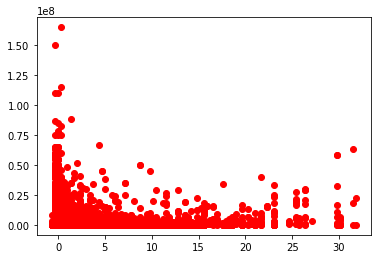

In [97]:
#посмотрим графики зависимостей целевой переменной
plt.scatter(X['stories_new'],y,  color='red')


In [98]:
#видим, что линейных зависимостей явно нет, прогоним линейную регрессию и убедимся, что все плохо

In [141]:
#функция расчета метрик
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

1. Линейная регрессия на по признакам 

'pool_new', 'baths_new', 'fireplace_new', 'beds_new', 'avg_school_dist', 'sqft_new', 'heating', 'cooling', 'stories_new', 'mls_new' ,'city','propertytype'
дала результаты
На тренировочной выборке коэффициент детерминации =  0.1924752898987776
На тестовой выборке коэффициент детерминации =  0.23277447179910915
Оценка для предсказания на тренировочном наборе
MSE = 2561827870978.58, RMSE = 1600571.11
Оценка для предсказания на тестовом наборе
MSE = 1744498996253.38, RMSE = 1320794.84

2. Линейная регрессия с признаками из пункта 1 + информация по преступности в штатах

На тренировочной выборке коэффициент детерминации =  0.18645708010101802
На тестовой выборке коэффициент детерминации =  0.2779111226522114
Оценка для предсказания на тренировочном наборе
MSE = 2513084000667.59, RMSE = 1585270.95
Оценка для предсказания на тестовом наборе
MSE = 2153251156983.99, RMSE = 1467396.05

3. Попробуем провести линейную регрессию на признаках отобранных LassoCV

На тренировочной выборке коэффициент детерминации =  0.18641499900684322
На тестовой выборке коэффициент детерминации =  0.27780818697166054
Оценка для предсказания на тренировочном наборе
MSE = 2513213991749.70, RMSE = 1585311.95
Оценка для предсказания на тестовом наборе
MSE = 2153558108635.22, RMSE = 1467500.63

4. Полиномиальная модель второй степери на двух признаках baths и sqft

На тренировочной выборке коэффициент детерминации =  0.08240698293540694
На тестовой выборке коэффициент детерминации =  0.09735981461013499
Оценка для предсказания на тренировочном наборе
MSE = 2834501135595.48, RMSE = 1683597.68
Оценка для предсказания на тестовом наборе
MSE = 2691650688028.59, RMSE = 1640625.09

5. Попробуем модель градиентного бустинга
Дает очень плохой результат на тестовой выборке

На тренировочной выборке коэффициент детерминации =  0.6369703537915004
На тестовой выборке коэффициент детерминации =  0.03414490166700912
Оценка для предсказания на тренировочном наборе
MSE = 1121420853576.94, RMSE = 1058971.60
Оценка для предсказания на тестовом наборе
MSE = 2880155993543.59, RMSE = 1697102.23


6. Пробуем модель RandomForestRegressor
На тренировочной выборке коэффициент детерминации =  0.6270103176452233
На тестовой выборке коэффициент детерминации =  0.22479792451724723
Оценка для предсказания на тренировочном наборе
MSE = 1152188016406.40, RMSE = 1073400.21
Оценка для предсказания на тестовом наборе
MSE = 2311633399008.40, RMSE = 1520405.67

7. Попробовать ввести новые признаки
8. Можно попробовать нейронную сеть, если будет время
9. Собрать модель, если она когда-то получится в API


Вывод: построить достойную модель - не получилось. 




1. Строим линейную модель с признаками 'pool_new', 'baths_new', 'fireplace_new', 'beds_new', 'avg_school_dist', 'sqft_new', 'heating', 'cooling', 'stories_new', 'mls_new' ,'city','propertytype'
2. Добавили столбец уровня убийств в штатах и прогнали модель заново. Никакого счастья не наступает r2 не превышает 0.1

In [153]:
#Линейная модель 
#коэффициент детерминации очень маленький R2 огромный, с такой ошибкой предсказания проще число выбирать рандомно
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=151)
reg = LinearRegression(fit_intercept =True).fit(X_train, y_train)
# сделаем пердсказания на обучающей и тестовой выборках
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
r2_test = r2_score(y_test,y_test_pred)
r2_train = r2_score(y_train,y_train_pred)
print('На тренировочной выборке коэффициент детерминации = ',r2_train)
print('На тестовой выборке коэффициент детерминации = ',r2_test)
print('Оценка для предсказания на тренировочном наборе')
print_regression_metrics(y_train,y_train_pred)
print('Оценка для предсказания на тестовом наборе')
print_regression_metrics(y_test,y_test_pred)


На тренировочной выборке коэффициент детерминации =  0.18641499900684322
На тестовой выборке коэффициент детерминации =  0.27780818697166054
Оценка для предсказания на тренировочном наборе
MSE = 2513213991749.70, RMSE = 1585311.95
Оценка для предсказания на тестовом наборе
MSE = 2153558108635.22, RMSE = 1467500.63


Если данных немного, то R-sq adj - более точная метрика качества прогнозирующей способности регрессии, так как она учтет количество факторов. Данных много, нет большой разницы, что использовать - R-sq или R-sq adj, они будут почти одинаковыми


3. Пробуем отобрать самые значимые признаки с помощью LassoCV() 
Алгоритм предложил удалить три признака городов. Попробуем с таким наборов признаков прогнать линейную регрессию
'city_washington',  'city_poinciana', 'city_chattanooga'

In [143]:
#Подберем признаки для построения модели
#ничего нового и интересного не узнали
def feature_selection():
    clf=LassoCV()
    sfm=SelectFromModel(clf,threshold=0.5)
    sfm.fit(X,y)
    print(sfm.get_support())
    return sfm.get_support() #возвращаем boolean список для фич

def remove_feature(bool_feature_list):
    i=0
    feature_remove_list=[] #storing the index of the columns that are to be removed
    for bol in bool_feature_list:
        if bol == False:
            feature_remove_list.append(i)
        else:
            pass
        i=i+1
    return X.drop(X.columns[feature_remove_list],axis=1)
    
         
bool_feature_list=feature_selection()
X=remove_feature(bool_feature_list)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True]


4. Полиномиальная модель на двух признаках  baths и sqft дала самые плохие результаты

In [168]:
#Полиномиальная модель
#Попробовали ввести полиномиальные признаки, тоже не помогло
#коэффициент детерминации очень маленький R2 огромный, с такой ошибкой предсказания проще число выбирать рандомно
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=151)
polyfeat=pp.PolynomialFeatures(degree=2)

#for_polinom_test = X_test[['baths_new','sqft_new']]
#for_polinom_train = X_train[['baths_new','sqft_new']]
X_train=polyfeat.fit_transform(X_train)
X_test=polyfeat.fit_transform(X_test)

#X_train_poly_dop=pd.dataFrame(X_train_poly_dop)
#X_test_poly_dop=pd.dataFrame(X_test_poly_dop)

#X_train[X_train_poly_dop.columns] = X_train_poly_dop
#X_test[X_test_poly_dop.columns] = X_test_poly_dop

poly=LinearRegression().fit(X_train,y_train)
y_train_pred = poly.predict(X_train)
y_test_pred = poly.predict(X_test)
r2_test = r2_score(y_test,y_test_pred)
r2_train = r2_score(y_train,y_train_pred)
print('На тренировочной выборке коэффициент детерминации = ',r2_train)
print('На тестовой выборке коэффициент детерминации = ',r2_test)
print('Оценка для предсказания на тренировочном наборе')
print_regression_metrics(y_train,y_train_pred)
print('Оценка для предсказания на тестовом наборе')
print_regression_metrics(y_test,y_test_pred)


На тренировочной выборке коэффициент детерминации =  0.08240698293540694
На тестовой выборке коэффициент детерминации =  0.09735981461013499
Оценка для предсказания на тренировочном наборе
MSE = 2834501135595.48, RMSE = 1683597.68
Оценка для предсказания на тестовом наборе
MSE = 2691650688028.59, RMSE = 1640625.09


5. Градиентный бустинг

In [173]:
from sklearn.ensemble import GradientBoostingRegressor

GB= GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
GB.fit(X_train, y_train)
y_train_pred = GB.predict(X_train)
y_test_pred = GB.predict(X_test)
r2_test = r2_score(y_test,y_test_pred)
r2_train = r2_score(y_train,y_train_pred)
print('На тренировочной выборке коэффициент детерминации = ',r2_train)
print('На тестовой выборке коэффициент детерминации = ',r2_test)
print('Оценка для предсказания на тренировочном наборе')
print_regression_metrics(y_train,y_train_pred)
print('Оценка для предсказания на тестовом наборе')
print_regression_metrics(y_test,y_test_pred)


На тренировочной выборке коэффициент детерминации =  0.6369703537915004
На тестовой выборке коэффициент детерминации =  0.03414490166700912
Оценка для предсказания на тренировочном наборе
MSE = 1121420853576.94, RMSE = 1058971.60
Оценка для предсказания на тестовом наборе
MSE = 2880155993543.59, RMSE = 1697102.23


6. RandomForestRegressor

In [175]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=300,
                              max_features=3,
                              random_state=100,
                              max_depth = 8,
                              min_samples_split = 3
                              )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
r2_test = r2_score(y_test,y_test_pred)
r2_train = r2_score(y_train,y_train_pred)
print('На тренировочной выборке коэффициент детерминации = ',r2_train)
print('На тестовой выборке коэффициент детерминации = ',r2_test)
print('Оценка для предсказания на тренировочном наборе')
print_regression_metrics(y_train,y_train_pred)
print('Оценка для предсказания на тестовом наборе')
print_regression_metrics(y_test,y_test_pred)

На тренировочной выборке коэффициент детерминации =  0.6270103176452233
На тестовой выборке коэффициент детерминации =  0.22479792451724723
Оценка для предсказания на тренировочном наборе
MSE = 1152188016406.40, RMSE = 1073400.21
Оценка для предсказания на тестовом наборе
MSE = 2311633399008.40, RMSE = 1520405.67


In [ ]:
7.

In [ ]:
features = list(range(0, 54))
target = 54

df = df[(df[target] == 1) | (df[target] == 2)]

In [ ]:
cover_train, cover_test = train_test_split(df, test_size=0.5)

cover_X_train, cover_y_train = cover_train[features], cover_train[target]
cover_X_test, cover_y_test = cover_test[features], cover_test[target]

In [ ]:
scaler = StandardScaler()
cover_X_train = scaler.fit_transform(cover_X_train)
cover_X_test = scaler.transform(cover_X_test)

In [ ]:
ef compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the classifier.
    
    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

In [ ]:
def generate_metafeatures(classifiers, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [ ]:
np.random.seed(42)

In [ ]:
cv = KFold(n_splits=10, shuffle=True)

stacked_features_train, stacked_features_test = generate_metafeatures([
    LogisticRegression(C=0.001, penalty='l1', solver='liblinear', max_iter=5000),
    LogisticRegression(C=0.001, penalty='l2', solver='liblinear', max_iter=5000),  
    RandomForestClassifier(n_estimators=300, n_jobs=-1),
    GradientBoostingClassifier(n_estimators=300)
], cover_X_train, cover_X_test, cover_y_train.values, cv)

In [ ]:
total_features_train = np.hstack([cover_X_train, stacked_features_train])
total_features_test = np.hstack([cover_X_test, stacked_features_test])

In [ ]:
np.random.seed(42)
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, cover_y_train)
accuracy_score(clf.predict(stacked_features_test), cover_y_test)

In [ ]:
X=X.loc[:,['baths_new','sqft_new']]

In [166]:
def for_alpha(model_feature,model_target):
    poly=pp.PolynomialFeatures(2)
    rcv=RidgeCV([1,10,100,60,70],cv=10)
    x=poly.fit_transform(model_feature)
    rcv.fit(x,model_target)
    return rcv.alpha_

x=for_alpha(X,y)
pipeline = make_pipeline(pp.PolynomialFeatures(2),Ridge(alpha=x))
pipeline=pipeline.fit(X_train,y_train)
y_train_pred=pipeline.predict(X_train)
y_test_pred=pipeline.predict(X_test)

r2_test = r2_score(y_test,y_test_pred)
r2_train = r2_score(y_train,y_train_pred)
print('На тренировочной выборке коэффициент детерминации = ',r2_train)
print('На тестовой выборке коэффициент детерминации = ',r2_test)
print('Оценка для предсказания на тренировочном наборе')
print_regression_metrics(y_train,y_train_pred)
print('Оценка для предсказания на тестовом наборе')
print_regression_metrics(y_test,y_test_pred)


MemoryError: 